## Setting up environment

### Load dependencies

In [40]:
%matplotlib inline

import numpy
import nibabel
import os
import matplotlib.pyplot as plt

# Useful functions
from nilearn.input_data import NiftiMasker
from os.path import join as opj
import sklearn.manifold
import scipy.cluster.hierarchy
import glob
from nipype.interfaces.base import Bunch


# Home directory
wd = os.getcwd()
subjdir = opj(wd, 'kalanit_fsl')
modeldir = opj(subjdir, 'Model')
bolddir = opj(subjdir, 'result', 'bold', 'highpass')
zdir = opj(subjdir, 'result', '1stlevel')

### Load BOLD and z-stat files

In [15]:
boldfiles = []
for root, dirs, files in os.walk(bolddir):
    for f in files:
        if f.endswith('.nii.gz'):
            boldfiles.append(opj(root, f))
            
ztemplate = opj(zdir, '_modelestimate%d', 'zstat%d.nii.gz')
zdata = numpy.empty((10, 10), dtype = object)
zdata_flat = numpy.copy(zdata)

for run in range(10):
    for cond in range(10):
        fname = ztemplate % (run, cond+1)
        img_data = nibabel.load(fname).get_data()
        img_flat = img_data.flatten()
        zdata[run, cond] = img_flat

### Load model information

In [16]:
# List of contrasts
condition_names = ['adult', 'child', 'body', 'limb',
                   'car', 'instrument', 'corridor',
                   'house', 'word', 'number'];

model_files = glob.glob(opj(subjdir, 'Model', '*.txt'))
subjectinfo = []

for r in range(len(model_files)):
    # Read model info
    model_f = open(model_files[r], 'r')
    model_str = model_f.read()
    model_info = [s.split('\t') for s in model_str.split('\r')]
    model_f.close()

    # Clean up model_info
    for i in range(len(model_info)):
        model_info[i][0] = int(model_info[i][0])

    # Get onsets
    all_onsets = [m[0] for m in model_info]
    run_dur = [list(set(numpy.diff(all_onsets)))]
    cond_durs = run_dur*len(condition_names)

    # Split onsets by condition
    cond_onsets = [[m[0] for m in model_info if m[2] == c] for c in condition_names]

    # Create Bunch object
    subjectinfo.insert(r, Bunch(conditions = condition_names,
                                onsets = cond_onsets,
                                durations = cond_durs))

## Compute within- and between-run correlations

Compute *all* correlations:

In [18]:
all_correlations = numpy.zeros((10, 10, 10, 10))

# Compute all correlations
for cond_i in range(10):
    for cond_j in range(10):
        for run_i in range(10):
            for run_j in range(10):
                data_i = zdata[run_i, cond_i]
                data_j = zdata[run_j, cond_j]
                r = numpy.corrcoef(data_i, data_j)[0, 1]
                all_correlations[cond_i, cond_j, run_i, run_j] = r

Compute *average* correlation for each pair of conditions, across runs:

In [38]:
rdm = numpy.zeros((10, 10))

for cond_i in range(10):
    for cond_j in range(10):
        # Get all correlations
        cond_ij = all_correlations[cond_i, cond_j, :, :]
        
        # Remove diagonals
        cond_ij = numpy.hstack((cond_ij[numpy.triu_indices(10, 1)],
                                cond_ij[numpy.tril_indices(10, 1)]))
        
        rdm[cond_i, cond_j] = numpy.mean(cond_ij)

## Display representational dissimilarity matrix

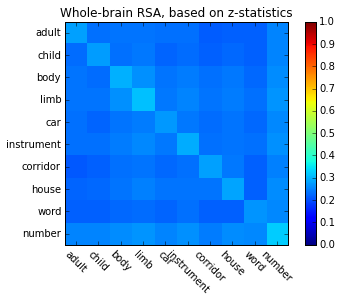

In [42]:
# Helper function to display RDM
def plot_mtx(mtx, labels, title):
    plt.figure()
    plt.imshow(mtx, interpolation = 'nearest')
    plt.xticks(range(len(mtx)), labels, rotation = -45)
    plt.yticks(range(len(mtx)), labels)
    plt.title(title)
    plt.clim((0, 1))
    plt.colorbar()
    
plot_mtx(rdm, condition_names, 'Whole-brain RSA, based on z-statistics')

(10, 10)